In [1]:
import pandas as pd
import numpy as np
import requests
import re
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## First, get the api key
with open('cfb_apikey.txt', 'r') as file:
    apikey = f"Bearer {file.read()}"

In [3]:
# specify base_url and endpoint url
url = "https://api.collegefootballdata.com/drives?seasonType=regular&year=2008&team=Utah"

In [4]:
headers = {
    "Authorization": apikey,
    "Content-Type": "application/json"
}

In [5]:
r = requests.get(url, headers=headers)
print(r.ok)

True


In [6]:
my_dict = r.json()

In [7]:
df = pd.DataFrame(my_dict)
df.columns

Index(['offense', 'offense_conference', 'defense', 'defense_conference',
       'game_id', 'id', 'drive_number', 'scoring', 'start_period',
       'start_yardline', 'start_yards_to_goal', 'start_time', 'end_period',
       'end_yardline', 'end_yards_to_goal', 'end_time', 'elapsed', 'plays',
       'yards', 'drive_result', 'is_home_offense', 'start_offense_score',
       'start_defense_score', 'end_offense_score', 'end_defense_score'],
      dtype='object')

In [8]:
columns_wanted = ['offense', 'defense', 'scoring', 'elapsed', 'plays', 'start_yards_to_goal', 'yards', 'drive_result']
df[columns_wanted]

,offense,defense,scoring,elapsed,plays,start_yards_to_goal,yards,drive_result
0,Michigan,Utah,False,"{'minutes': 1, 'seconds': 32}",3,71,2,PUNT
1,Michigan,Utah,True,"{'minutes': 2, 'seconds': 8}",4,26,26,PASSING TD
2,Utah,Michigan,True,"{'minutes': 3, 'seconds': 42}",8,75,75,RUSHING TD
3,Michigan,Utah,True,"{'minutes': 2, 'seconds': 20}",6,50,17,FG GOOD
4,Utah,Michigan,True,"{'minutes': 6, 'seconds': 14}",14,77,66,FG GOOD
...,...,...,...,...,...,...,...,...
309,Utah,BYU,True,"{'seconds': 4, 'minutes': 0}",1,4,4,PASSING TD
310,BYU,Utah,False,"{'minutes': 3, 'seconds': 58}",8,75,56,INT
311,Utah,BYU,True,"{'minutes': 5, 'seconds': 24}",9,29,29,PASSING TD
312,BYU,Utah,False,"{'seconds': 32, 'minutes': 0}",4,67,13,INT


In [9]:
df_to_use = df[columns_wanted].copy()
# Filter out rows with specific values in 'drive_result due to misleading data'
df_to_use= df_to_use[~df_to_use['drive_result'].isin(['INT RETURN TOUCH', 'FUMBLE RETURN TD', 'Uncategorized'])]


# Create the 'points' column in the copied DataFrame
df_to_use['off_points_gained'] = df_to_use['drive_result'].apply(lambda x: -2 if 'SF' in x 
                                                      else 3 if 'GOOD' in x 
                                                      else 6 if 'TD' in x
                                                      else 0)
# Replace True/False with Binary response (1 = True, 0 = False)
df_to_use['scoring'] = df_to_use['scoring'].astype(int)
# Convert 'elapsed' column to decimal minutes
df_to_use['elapsed'] = df_to_use['elapsed'].apply(lambda x: x['minutes'] + x['seconds'] / 60)

In [10]:
# Verify that the each situation is correct for off_points_gained, one at a time
df_to_use[df_to_use['drive_result'] == 'SF'].head()

,offense,defense,scoring,elapsed,plays,start_yards_to_goal,yards,drive_result,off_points_gained
87,Air Force,Utah,1,1.816667,4,80,-20,SF,-2


In [11]:
df_to_use['drive_result'].unique()

array(['PUNT', 'PASSING TD', 'RUSHING TD', 'FG GOOD', 'INT',
       'END OF HALF', 'FUMBLE', 'TURNOVER ON DOWNS', 'END OF GAME', 'SF',
       'FG MISSED'], dtype=object)

In [12]:
df_to_use

,offense,defense,scoring,elapsed,plays,start_yards_to_goal,yards,drive_result,off_points_gained
0,Michigan,Utah,0,1.533333,3,71,2,PUNT,0
1,Michigan,Utah,1,2.133333,4,26,26,PASSING TD,6
2,Utah,Michigan,1,3.700000,8,75,75,RUSHING TD,6
3,Michigan,Utah,1,2.333333,6,50,17,FG GOOD,3
4,Utah,Michigan,1,6.233333,14,77,66,FG GOOD,3
...,...,...,...,...,...,...,...,...,...
309,Utah,BYU,1,0.066667,1,4,4,PASSING TD,6
310,BYU,Utah,0,3.966667,8,75,56,INT,0
311,Utah,BYU,1,5.400000,9,29,29,PASSING TD,6
312,BYU,Utah,0,0.533333,4,67,13,INT,0


In [13]:
df_to_use.to_csv('dataset.csv')

In [123]:
# Convert DataFrame to HTML
#df_html = df_to_use.to_html(index=False)

# Save the HTML table to a file
#with open("dataframe.html", "w") as file:
    #file.write(df_html)

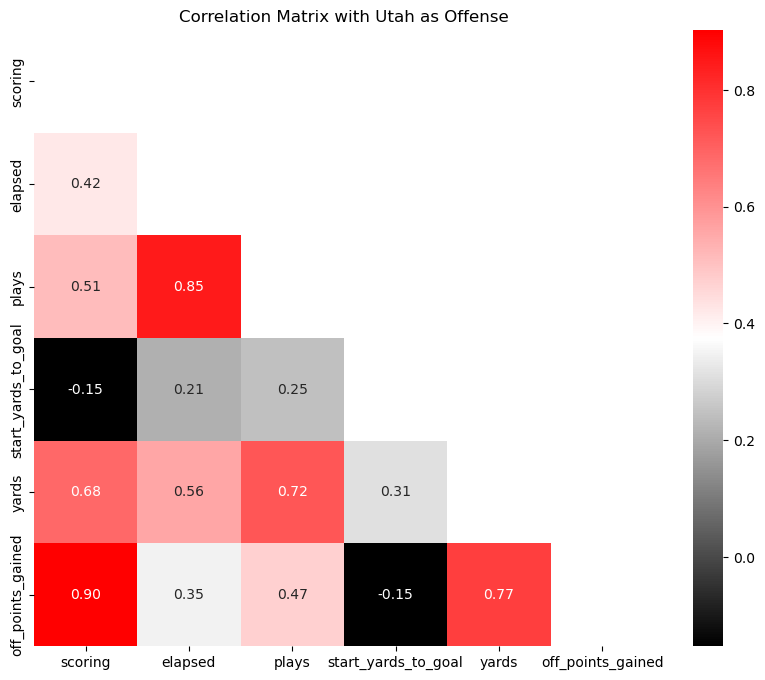

In [85]:
# Filter rows where 'offense' is 'Utah' and then select numeric columns
numeric_df = df_to_use[df_to_use['offense'] == 'Utah'].select_dtypes(include=['number'])


# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", [(0, "black"), (0.5, "white"), (1, "red")]
)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with the custom colormap and mask
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap=cmap, fmt=".2f")
plt.title("Correlation Matrix with Utah as Offense")
plt.show()


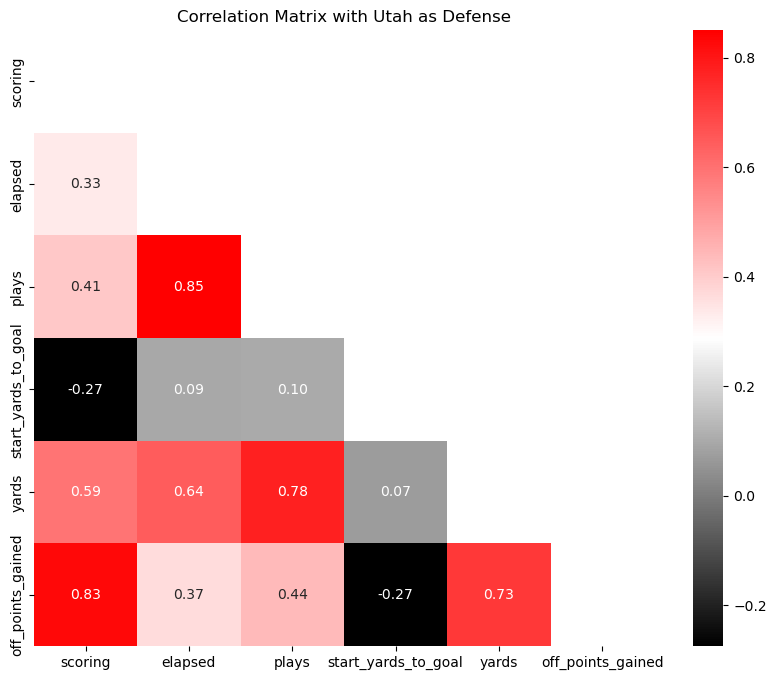

In [86]:
# Filter rows where 'defense' is 'Utah' and then select numeric columns
numeric_df2 = df_to_use[df_to_use['defense'] == 'Utah'].select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix2 = numeric_df2.corr()

# Create a mask for the upper triangle
mask2 = np.triu(np.ones_like(correlation_matrix2, dtype=bool))

# Plot the heatmap with the custom colormap and mask
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix2, annot=True, mask=mask2, cmap=cmap, fmt=".2f")
plt.title("Correlation Matrix with Utah as Defense")
plt.show()

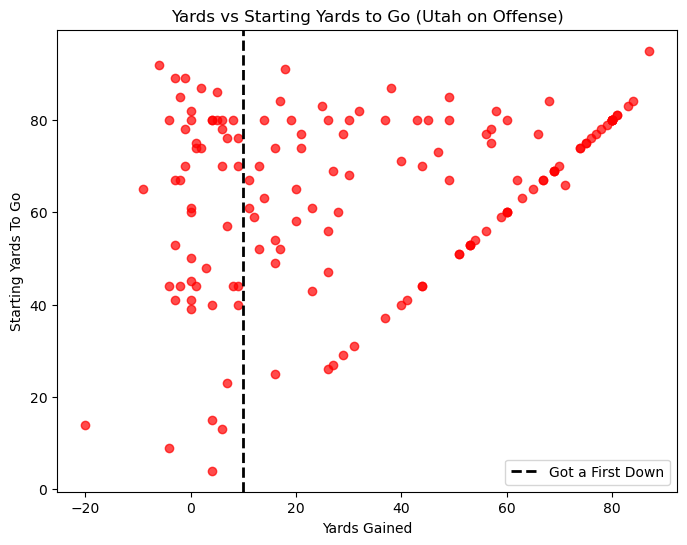

In [95]:
# Scatter plot for yards vs yards to go (Utah on Offense)
plt.figure(figsize=(8, 6))
plt.scatter(numeric_df['yards'], numeric_df['start_yards_to_goal'], alpha=0.7, color='red')
plt.xlabel("Yards Gained")
plt.ylabel("Starting Yards To Go")
plt.title("Yards vs Starting Yards to Go (Utah on Offense)")
# Add a vertical line at x=10 for "Typical First Down"
plt.axvline(x=10, color='black', linestyle='--', linewidth=2, label="Got a First Down")

# Add legend to label the vertical line
plt.legend(loc='lower right')
plt.show()


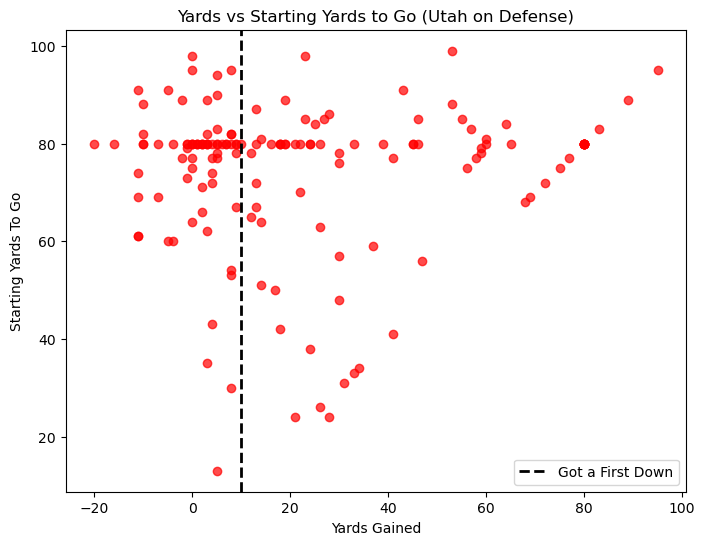

In [96]:
# Scatter plot for yards vs yards to go (Utah on Defense)
plt.figure(figsize=(8, 6))
plt.scatter(numeric_df2['yards'], numeric_df2['start_yards_to_goal'], alpha=0.7, color='red')
plt.xlabel("Yards Gained")
plt.ylabel("Starting Yards To Go")
plt.title("Yards vs Starting Yards to Go (Utah on Defense)")
# Add a vertical line at x=10 for "Typical First Down"
plt.axvline(x=10, color='black', linestyle='--', linewidth=2, label="Got a First Down")

# Add legend to label the vertical line
plt.legend(loc='lower right')
plt.show()

/var/folders/5m/rf39vb_x2j93b0k9hv2dzgbr0000gn/T/ipykernel_10736/2510593364.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([not_scored_data, scored_data], labels=['Did Not Score', 'Scored'])


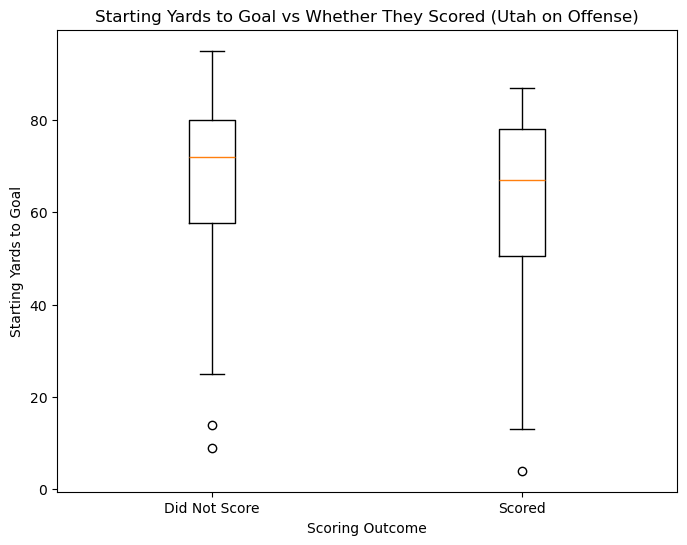

In [103]:
# Separate the data into two groups based on 'scoring'
scored_data = numeric_df[numeric_df['scoring'] == 1]['start_yards_to_goal']
not_scored_data = numeric_df[numeric_df['scoring'] == 0]['start_yards_to_goal']

# Box plot for start_yards_to_goal, grouped by whether they scored
plt.figure(figsize=(8, 6))
plt.boxplot([not_scored_data, scored_data], labels=['Did Not Score', 'Scored'])
plt.xlabel("Scoring Outcome")
plt.ylabel("Starting Yards to Goal")
plt.title("Starting Yards to Goal vs Whether They Scored (Utah on Offense)")
plt.show()

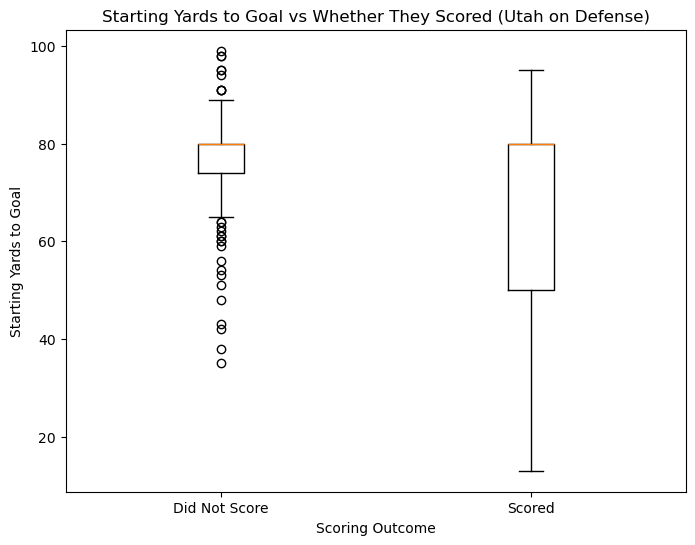

In [120]:
# Separate the data into two groups based on 'scoring'
scored_data = numeric_df2[numeric_df2['scoring'] == 1]['start_yards_to_goal']
not_scored_data = numeric_df2[numeric_df2['scoring'] == 0]['start_yards_to_goal']

# Box plot for start_yards_to_goal, grouped by whether they scored
plt.figure(figsize=(8, 6))
plt.boxplot([not_scored_data, scored_data], tick_labels=['Did Not Score', 'Scored'])
plt.xlabel("Scoring Outcome")
plt.ylabel("Starting Yards to Goal")
plt.title("Starting Yards to Goal vs Whether They Scored (Utah on Defense)")
plt.show()

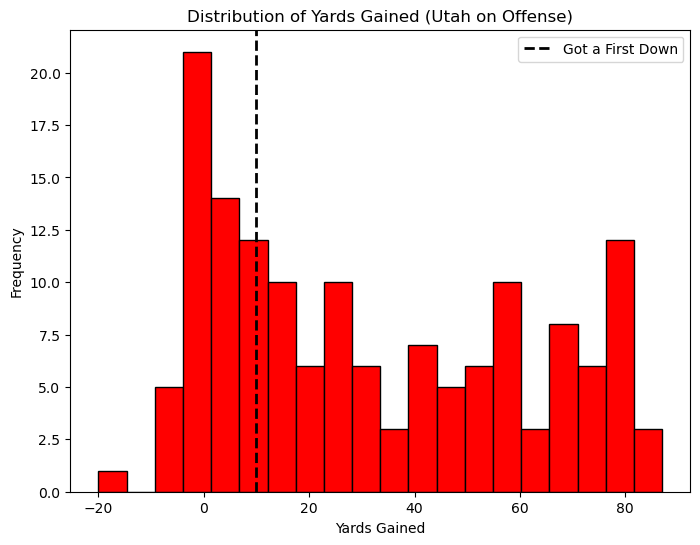

In [111]:
# Histogram for yards when on Offense
plt.figure(figsize=(8, 6))
plt.hist(numeric_df['yards'], bins=20, color='red', edgecolor='black')
plt.xlabel("Yards Gained")
plt.ylabel("Frequency")
plt.title("Distribution of Yards Gained (Utah on Offense)")
# Add a vertical line at x=10 for "Typical First Down"
plt.axvline(x=10, color='black', linestyle='--', linewidth=2, label="Got a First Down")

# Add legend to label the vertical line
plt.legend(loc='upper right')
plt.show()

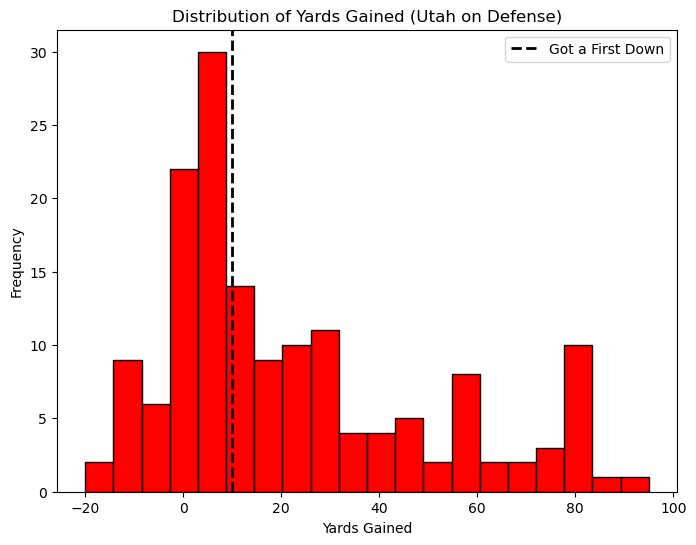

In [113]:
# Histogram for yards when on Defense
plt.figure(figsize=(8, 6))
plt.hist(numeric_df2['yards'], bins=20, color='red', edgecolor='black')
plt.xlabel("Yards Gained")
plt.ylabel("Frequency")
plt.title("Distribution of Yards Gained (Utah on Defense)")
# Add a vertical line at x=10 for "Typical First Down"
plt.axvline(x=10, color='black', linestyle='--', linewidth=2, label="Got a First Down")

# Add legend to label the vertical line
plt.legend(loc='upper right')
plt.show()

In [121]:
print(f"Utah's average time on offense was: {numeric_df['elapsed'].mean()}")
print(f"Utah's average time on defense was: {numeric_df2['elapsed'].mean()}")

print(f"Utah's average offensive points gained was: {numeric_df['off_points_gained'].mean()}")
print(f"Utah's opponents average offensive points gained was: {numeric_df2['off_points_gained'].mean()}")

print(f"The proportion of Utah's drives ending with points was: {numeric_df['scoring'].mean()}")
print(f"The proportion of Utah's opponent's drives ending with points was: {numeric_df2['scoring'].mean()}")

Utah's average time on offense was: 2.6599099099099095
Utah's average time on defense was: 2.0763440860215057
Utah's average offensive points gained was: 2.391891891891892
Utah's opponents average offensive points gained was: 1.070967741935484
The proportion of Utah's drives ending with points was: 0.4864864864864865
The proportion of Utah's opponent's drives ending with points was: 0.23870967741935484
